# Fruits and Vegetables Image Recognition


```
# This is formatted as code
```



# Install required packages (no kagglehub needed)

In [ ]:
!pip install tensorflow numpy matplotlib scipy

: 

: 

In [10]:
# Using local Fruits-360 dataset
DATA_DIR = './Fruits-360 dataset/fruits-360_original-size/fruits-360-original-size'

print("Path to dataset files:", DATA_DIR)

Path to dataset files: ./Fruits-360 dataset/fruits-360_original-size/fruits-360-original-size


Info about this dataset :
- Train folder contains 100 images per category.
- Test : contains 10 images per category.
- validation: contiants 10 images per category.

The included food items are:

Fruits: Banana, Apple, Pear, Grapes, Orange, Kiwi, Watermelon, Pomegranate, Pineapple, Mango
Vegetables: Cucumber, Carrot, Capsicum, Onion, Potato, Lemon, Tomato, Radish, Beetroot, Cabbage, Lettuce, Spinach, Soybean, Cauliflower, Bell Pepper, Chilli Pepper, Turnip, Corn, Sweetcorn, Sweet Potato, Paprika, Jalapeño, Ginger, Garlic, Peas, Eggplant

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt


## ⚙️ Model Training & TFLite Conversion Steps

This process assumes you are using Python with TensorFlow/Keras and the MobileNetV2 architecture for Transfer Learning.

### **I. Data Preparation**

1.  **Organize Dataset:** Ensure your images are split and placed into three distinct directories: `train`, `validation`, and `test`. The subdirectories within each must be named according to their **class** (e.g., `Ripe_Apple`, `Unripe_Apple`).
2.  **Define Hyperparameters:** Set the target `IMAGE_SIZE` (e.g., $224 \times 224$), `BATCH_SIZE`, and number of `EPOCHS`.
3.  **Load Data Generators:** Use `ImageDataGenerator` to load images from the directories.
    * Apply **rescaling** (e.g., `1./255`) and **Data Augmentation** (e.g., rotation, horizontal flip) to the training set.
    * Apply only **rescaling** to the validation set.
4.  **Determine Classes:** Automatically retrieve the total number of classification classes (`NUM_CLASSES`) from the data generator.

---

### **II. Model Training (CNN)**

5.  **Load Base Model:** Load the pre-trained **MobileNetV2** model, excluding its top classification layer (`include_top=False`), and using weights pre-trained on ImageNet.
6.  **Freeze Base Model:** Set the `base_model.trainable = False` to prevent the pre-trained weights from changing during the initial training phase.
7.  **Build Custom Head:** Create a `Sequential` model that stacks:
    * The `base_model`.
    * A `GlobalAveragePooling2D` layer.
    * One or more `Dense` layers (ReLU activation recommended).
    * A final `Dense` layer with `NUM_CLASSES` neurons and `softmax` activation.
8.  **Compile Model:** Configure the training process using:
    * **Optimizer:** `Adam` (with a low learning rate, e.g., $0.0001$).
    * **Loss Function:** `categorical_crossentropy`.
    * **Metrics:** `['accuracy']`.
9.  **Fit Model:** Train the model using the training data, while monitoring performance against the validation data over the specified number of epochs.
10. **Save Keras Model:** Save the trained model in the standard Keras format (e.g., `.h5` or `SavedModel`).

---

### **III. TFLite Conversion & Deployment Prep**

11. **Instantiate Converter:** Use `tf.lite.TFLiteConverter.from_keras_model()` with the saved Keras model.
12. **Optimize:** Set `converter.optimizations = [tf.lite.Optimize.DEFAULT]` to apply **Post-Training Quantization**. This significantly reduces the model size and improves mobile performance.
13. **Convert & Save TFLite:** Execute the conversion and save the result as the optimized TFLite file (e.g., `ripeness_model.tflite`).
14. **Save Labels:** Extract the ordered list of class names from the data generator and save them to a plain text file (e.g., `ripeness_labels.txt`).
15. **Deploy Assets:** Place both the `.tflite` model file and the `.txt` labels file into the `assets/` directory of your Flutter project.

Repeat steps 1 through 15 for the **Fruit Type** and **Fruit Disease** datasets to complete your three-model architecture.

## 1. Data & Model prep


In [12]:
# Hyper params - OPTIMIZED FOR SPEED
BATCH_SIZE = 128  # Increased from 64 for faster processing
IMAGE_SIZE = (100, 100)  # Reduced from 180x180 - MobileNetV2 works well with smaller images
EPOCHS = 12

TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
VALID_DIR = os.path.join(DATA_DIR, 'Validation')
TEST_DIR = os.path.join(DATA_DIR, 'Test')

In [13]:
# load the data with ImageDataGenerator to load images , resize them, and apply basic data augmentation(rotaiton, flips...) to improve the model's robustness.
# Rescale to [0, 1]
train_datagen = ImageDataGenerator(
    rescale = 1./255 ,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# no augmentation for validaiton
valid_datagen = ImageDataGenerator(
    rescale = 1./255
)
# load the training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode= 'categorical',
    shuffle=True
)
validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode= 'categorical',
    shuffle=False
)
# the number of classes for the final layer
NUM_CLASSES = train_generator.num_classes
print(f"Total classes detected : {NUM_CLASSES}")

Found 39833 images belonging to 112 classes.
Found 19921 images belonging to 112 classes.
Total classes detected : 112


![img](https://encrypted-tbn3.gstatic.com/licensed-image?q=tbn:ANd9GcS8ZAQqtM-09H9jSR8hOrkmPZkc9c72vG4q97zfwxLmV5101IvOKMpveIKsUGEGooWe-VT6HqSqqps5EPS0vxdXeJ5tckxYrQwiIAtTxLSFUG_rcwE)

In [14]:
# Load base model
# Load MobileNetV2 pre-trained on ImageNet, without the top classification layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMAGE_SIZE + (3,),
    include_top = False,
    weights = 'imagenet'
)
# Freeze the base model to prevent weights form being updated during the training
base_model.trainable = False

/tmp/ipykernel_138717/3072170236.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [15]:
# Build the custom classififer Head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation = 'relu'),
    Dropout(0.2),# regularization to prevent overfitting
    Dense(NUM_CLASSES, activation = 'softmax') # final classification layer
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 112)            │        14,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,436,400 (9.29 MB)

 Trainable params: 178,416 (696.94 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# 2. Training

In [17]:
history = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = validation_generator
)

Epoch 1/12
312/312 ━━━━━━━━━━━━━━━━━━━━ 193s 612ms/step - accuracy: 0.1501 - loss: 3.8845 - val_accuracy: 0.4276 - val_loss: 2.4465
Epoch 2/12
312/312 ━━━━━━━━━━━━━━━━━━━━ 165s 530ms/step - accuracy: 0.4153 - loss: 2.2612 - val_accuracy: 0.6629 - val_loss: 1.3944
Epoch 3/12
312/312 ━━━━━━━━━━━━━━━━━━━━ 164s 527ms/step - accuracy: 0.5512 - loss: 1.6223 - val_accuracy: 0.7538 - val_loss: 0.9955
Epoch 4/12
312/312 ━━━━━━━━━━━━━━━━━━━━ 165s 529ms/step - accuracy: 0.6295 - loss: 1.2974 - val_accuracy: 0.8112 - val_loss: 0.7754
Epoch 5/12
312/312 ━━━━━━━━━━━━━━━━━━━━ 185s 594ms/step - accuracy: 0.6797 - loss: 1.0960 - val_accuracy: 0.8382 - val_loss: 0.6560
Epoch 6/12
312/312 ━━━━━━━━━━━━━━━━━━━━ 163s 524ms/step - accuracy: 0.7161 - loss: 0.9594 - val_accuracy: 0.8621 - val_loss: 0.5581
Epoch 7/12
312/312 ━━━━━━━━━━━━━━━━━━━━ 192s 616ms/step - accuracy: 0.7406 - loss: 0.8633 - val_accuracy: 0.8782 - val_loss: 0.4932
Epoch 8/12
312/312 ━━━━━━━━━━━━━━━━━━━━ 178s 570ms/step - accuracy: 0.7619 -

In [18]:
# save the trained keras model for potential future use
model.save('ripness_cnn_model.h5')

# 3. Plotting results

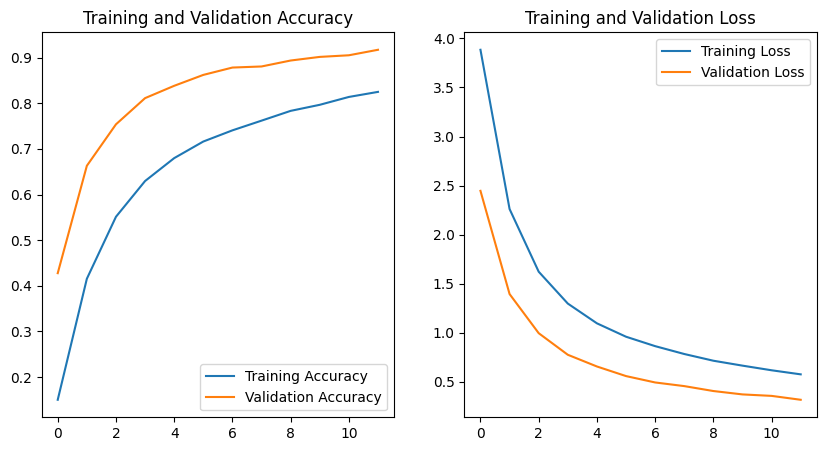

In [19]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)  # Fixed: was NUM_EPOCHS, should be EPOCHS

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 4. Convert the Keras model to TFLite

In [20]:
# Initialize the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply default optimization (Post-Training Quantization) for smaller size and faster inference
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model file
tflite_model_path = 'ripeness_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")

INFO:tensorflow:Assets written to: /tmp/tmp8n9xk6y5/assets


INFO:tensorflow:Assets written to: /tmp/tmp8n9xk6y5/assets


Saved artifact at '/tmp/tmp8n9xk6y5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 112), dtype=tf.float32, name=None)
Captures:
  140584282331024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140584282326992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140584282326608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140584282330832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140584282332176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140584282331600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140584282331792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140584282331984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140584282331408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140584282333136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14058428

W0000 00:00:1764948018.982862  138717 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764948018.982880  138717 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-05 16:20:18.983153: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8n9xk6y5
2025-12-05 16:20:18.991586: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-05 16:20:18.991605: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp8n9xk6y5
I0000 00:00:1764948019.061963  138717 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-12-05 16:20:19.075368: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-05 16:20:19.511291: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp8n9xk6y5
2025-12-05 16:20:19.625898: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

# 5. Save the Label map
since the flutter pap needs a lsit f the class names in the correct order to interpret the model's output

In [21]:
# Get class indices and map them to class names
labels = sorted(train_generator.class_indices.items(), key=lambda x: x[1])
class_names = [name for name, index in labels]

# Save class names to a text file
labels_file_path = 'ripeness_labels.txt'
with open(labels_file_path, 'w') as f:
    f.write('\n'.join(class_names))

print(f"Label map saved to: {labels_file_path}")
print("Final Classes:", class_names)

Label map saved to: ripeness_labels.txt
Final Classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Core 1', 'Apple Red Yellow 2', 'Apple worm 1', 'Avocado Black 1', 'Avocado Black 2', 'Avocado Green 1', 'Banana 3', 'Banana 4', 'Beans 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Cabbage red 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cherimoya 1', 'Cherry 3', 'Cherry 4', 'Cherry 5', 'Cherry Rainier 2', 'Cherry Rainier 3', 'Cherry Sour 1', 'Cherry Wax Red 2', 'Cherry Wax Red 3', 'Cherry Wax not ripen 1', 'Cherry Wax not ripen 2', 'Cucumber 1', 'Cucumber 10', 'Cucumber 11', 'Cucumber 3', 'Cucumber 4', 'Cucumber 5', 'Cucumber 6', 'Cucumber 7', 'Cucumber 8', 'Cucumber 9', 'Gooseberry 1', 'Grape not ripen 1', 'Nectarine Flat 2', 'Nut 1', 'Nut 2', 'Nut 3', 'Nut 4', 'Nut 5', 'Onion 2', 'Onion Red 2', 'Onion White Peeled